<a href="https://colab.research.google.com/github/XrayAMD/IBM-Telecom-Data-ML-Exploration/blob/main/IBMAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom Customer Churn IBM Dataset Machine Learning Analysis

**Author:** Alex Dunn

---

In this notebook we will be exploring an important topic in business, customer churn. Given data on our customers, we would like to know what factors contribute towards the customer stopping services with our company. Using this information, we can see what customers are at risk for stopping service and target our efforts to retain these high risk customers. In this notebook, we will do feature engineering, followed by model creation and evaluation on various machine learning techniques. At the end, we will analyze side by side model comparison, diving into the pros and cons of each model, and which model makes the most sense for use in our churn prediction.

# **Table of Contents**

1. [Imports](#scrollTo=8d7fb5a9)

2. [Loading the data](#scrollTo=a16931ed)

3. [Visualizing the Churn Dataset](#scrollTo=kB7C8szw8AXx)

4. [Machine Learning Models and Evaluation](#scrollTo=fd098f22)
    * 4.1 [Logistic Regression With Feature Engineering](#scrollTo=fd098f22)

    * 4.2 [Decision Trees - Random Forest With HyperParameter Optimization](#scrollTo=ZJoWWyaTY9vM)

    * 4.3 [Decision Trees - XGBoost](#scrollTo=aIWoTmq1ID9K)

5. [Visualizing All of the Models Together](#scrollTo=o9wBimMf8U0q)

6. [Analysis](#scrollTo=PgO0tIsuvLQR)



# **Imports**

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import os
import random
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import seaborn as sns

np.random.seed(42)
random.seed(42)


#**Loading the data**

In [ ]:
path = kagglehub.dataset_download("yeanzc/telco-customer-churn-ibm-dataset")
excel_file_path = os.path.join(path, 'Telco_customer_churn.xlsx')
df = pd.read_excel(excel_file_path)
# Churn Label is redunant column on Churn value
# Churn Score is IBM predictive value for churning that we won't use on our own predictions
# Lat Long is redundant on Lat and Long
# Churn Reason is not a column we can predict churn on
# count is always 1

# categorical - country, state, city, zip code, gender, senior citizen, partner, phone service, multiple lines, internet service,
# online security, online backup, device protection, tech support, streaming tv, streaming movies, contract, paperless billing,
# payment method

# numerical - count, monthly charges, total charges, tenure months

# spatial - country, state, city, zip code, lat, long
# note that country, state, city, and zip code are difficult
# to integrate as predictors in our models.  consider that
# by adding zip code, we could be adding thousands of
# categories with just a few points each, resulting in
# heavy overfitting and little prediective power.

Using Colab cache for faster access to the 'telco-customer-churn-ibm-dataset' dataset.


#**Visualizing the Churn Dataset**

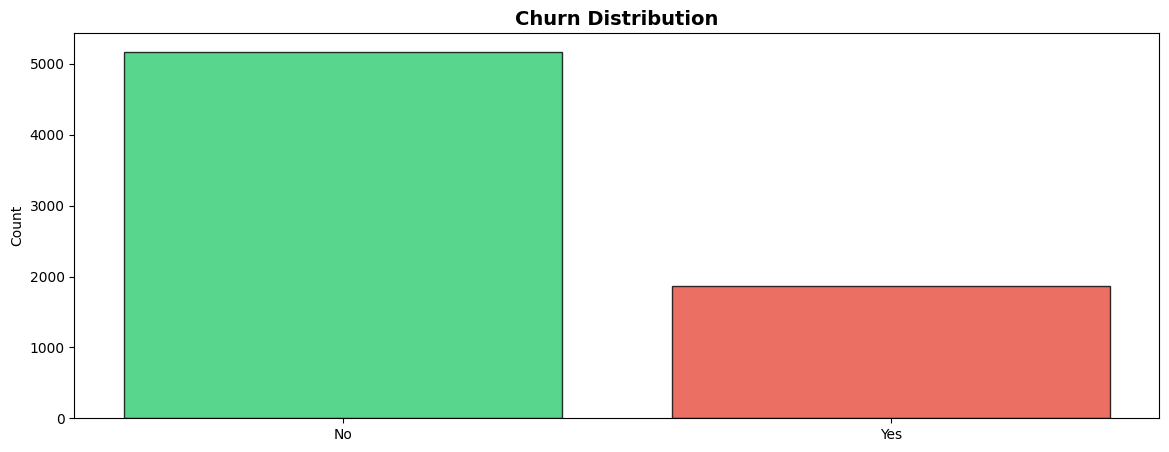

In [ ]:
plt.figure(figsize=(14, 5))
churn_counts = df['Churn Value'].value_counts()
colors = ['#2ecc71', '#e74c3c']
plt.bar(churn_counts.index, churn_counts.values, color=colors, alpha=0.8, edgecolor='black')
plt.title('Churn Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Count')
labels = ["No", "Yes"]
x = np.arange(len(labels))
plt.xticks(x, labels)
plt.show()

#**Logistic Regression With Feature Engineering**
In this model, we will use all of our features without the spatial data, convert categorical vars into numeric columns for the regression, and run logistic regression on data.  We also standardize numerical vars to not include distortion on scale.

In [ ]:
def make_roc_curve(y_test, y_hat):
  fpr, tpr, thresholds = roc_curve(y_test, y_hat)
  roc_auc = auc(fpr, tpr)

  # Plot
  plt.figure(figsize=(6,6))
  plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC)')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

In [ ]:
numerical = ['Monthly Charges', 'Total Charges', 'Tenure Months', 'Latitude', 'Longitude']
categorical = ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines',
               'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
               'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce').fillna(0)


X = df[numerical + categorical]
y = df['Churn Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical)
])
model = Pipeline([
    ('preprocess', preprocessor),
    ('logreg', LogisticRegression())
])
model.fit(X_train, y_train)
y_pred_log = model.predict(X_test)
y_hat_log = model.predict_proba(X_test)[:,1] # this has two columns, we want the positive class
logreg = model.named_steps['logreg']
betas = logreg.coef_[0]

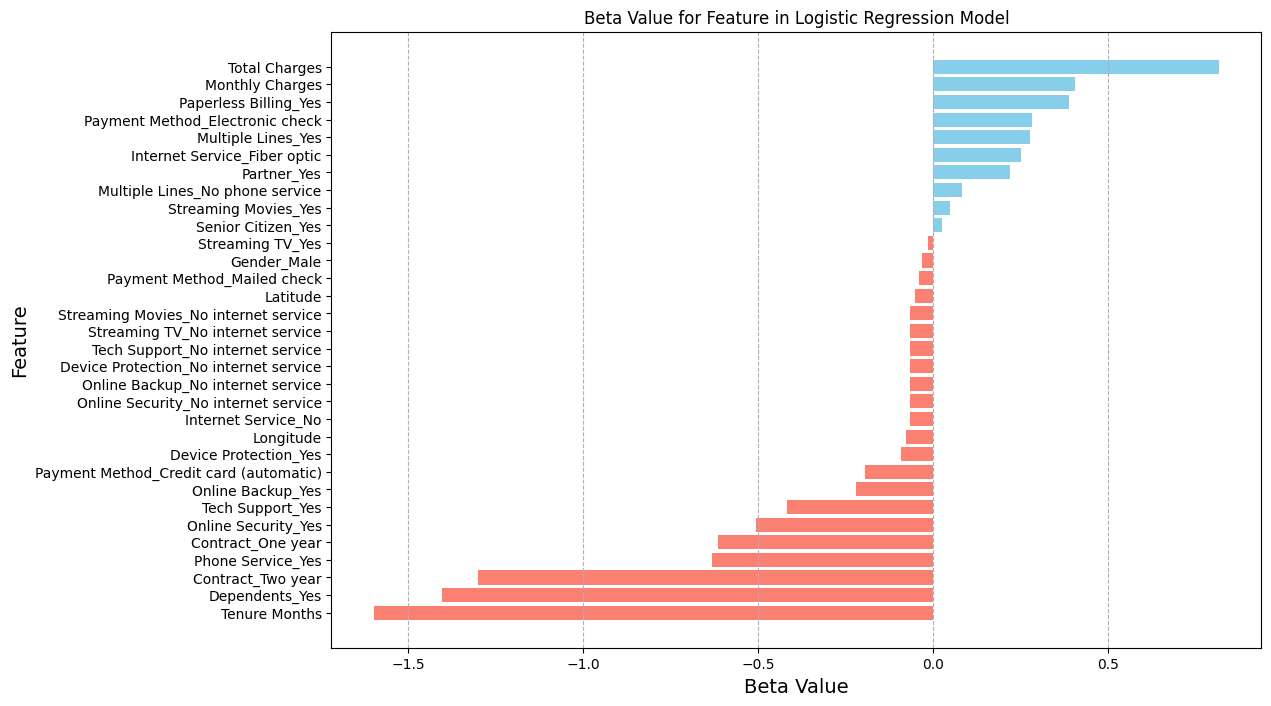

In [ ]:
ohe = preprocessor.named_transformers_['cat']
categorical_names = ohe.get_feature_names_out(categorical)

# Combine all feature names in order
all_feature_names = list(numerical) + list(categorical_names)
feature_with_beta = []
for index, feature_name in enumerate(all_feature_names):
  feature_with_beta.append((feature_name, betas[index]))
feature_with_beta.sort(key=lambda x: x[1])
features = [x for x,_ in feature_with_beta]
betas = [x for _, x in feature_with_beta]

plt.figure(figsize=(12, 8))
plt.barh(features, betas, color=np.where(np.array(betas) > 0, 'skyblue', 'salmon'))
plt.xlabel('Beta Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Beta Value for Feature in Logistic Regression Model')
plt.grid(axis='x', linestyle='--')
plt.show()

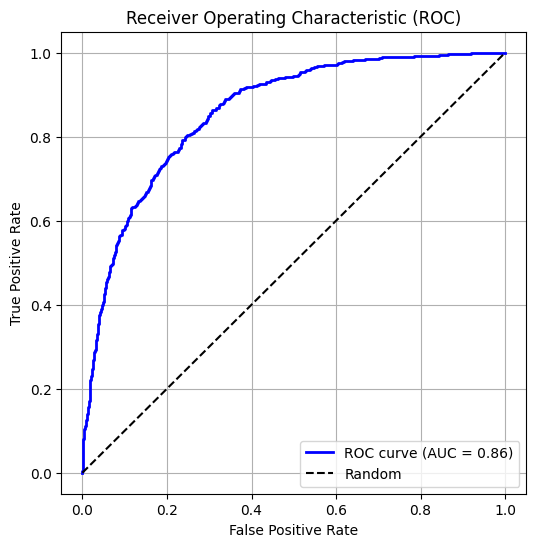

ROC-AUC: 0.8598065300284221


In [ ]:
make_roc_curve(y_test, y_hat_log)
print(f"ROC-AUC: {roc_auc_score(y_test, y_hat_log)}")

In [ ]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1684
           1       0.68      0.60      0.64       641

    accuracy                           0.81      2325
   macro avg       0.77      0.75      0.76      2325
weighted avg       0.81      0.81      0.81      2325



From this simple model, we get surprisingly high accuracy at around 80%, and an F1 score of .62.  The dataset is unbalanced, as slightly over a quarter of the dataset is a churn.  Therefore, we can get reasonably high accuracy just by predicting no churn for all the data.  We have an acceptable but not great F1 score.  Looking at the betas in the model, we see the highest contributing variable towards a churn is having internet service fiber optic.  

The variable contributing the most (highest postitive beta score) towards a churn is total charges, while the var contributing the most towards not churning (lowest negative beta) is tenure months. Near zero coefficients, we see largely irrelevant variables like gender.



#**Decision Trees - Random Forest With HyperParameter Optimization**
Now that we have completed the most basic model for prediction, let us see what sort of predictive power we can get from a random forest.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

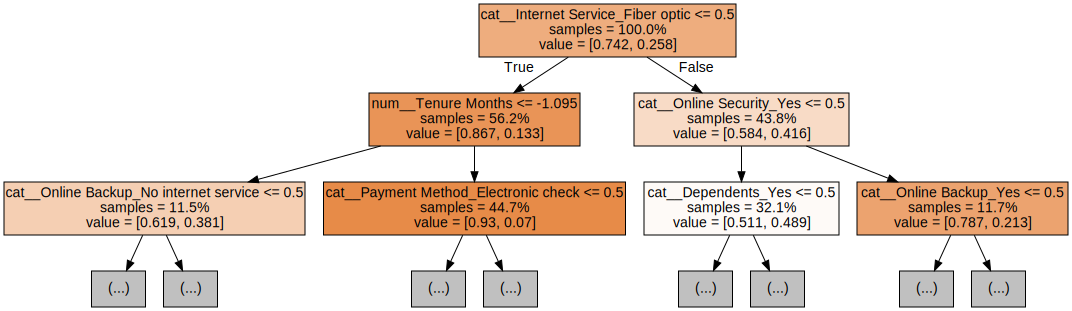

In [ ]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,30),
              'max_features': ['sqrt']}

rf = RandomForestClassifier(oob_score=True, random_state=42)
# out of bag means some data is not chosed for each tree's sample.  we then in prediction use every tree where that sample was not used (N > 5000 is good for this)
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)
model = Pipeline([
    ('preprocess', preprocessor),
    ('rf', rand_search)
])
model.fit(X_train, y_train)
y_pred_rf = model.predict(X_test)
y_hat_rf = model.predict_proba(X_test)[:,1]
rf_model = model.named_steps['rf']
preprocessor_fitted = model.named_steps['preprocess']
feature_names_out = preprocessor_fitted.get_feature_names_out()
tree = rf_model.best_estimator_.estimators_[0]
dot_data = export_graphviz(tree,
                            feature_names=feature_names_out,
                            filled=True,
                            max_depth=2,
                            impurity=False,
                            proportion=True)
graph = graphviz.Source(dot_data)
display(graph)

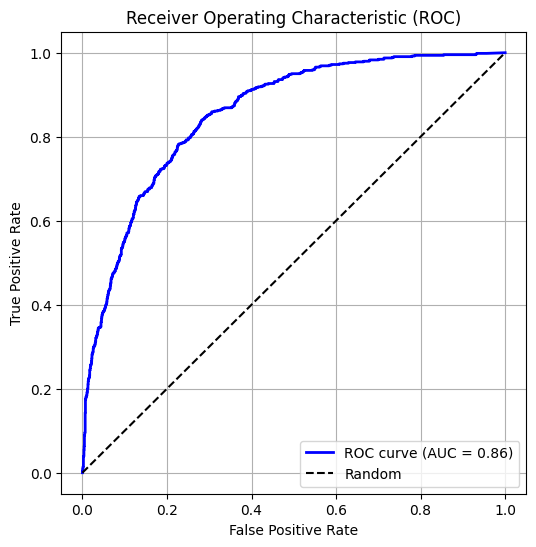

ROC-AUC: 0.855416770114985


In [ ]:
make_roc_curve(y_test, y_hat_rf)
print(f"ROC-AUC: {roc_auc_score(y_test, y_hat_rf)}")

In [ ]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1684
           1       0.69      0.53      0.60       641

    accuracy                           0.80      2325
   macro avg       0.76      0.72      0.73      2325
weighted avg       0.79      0.80      0.80      2325



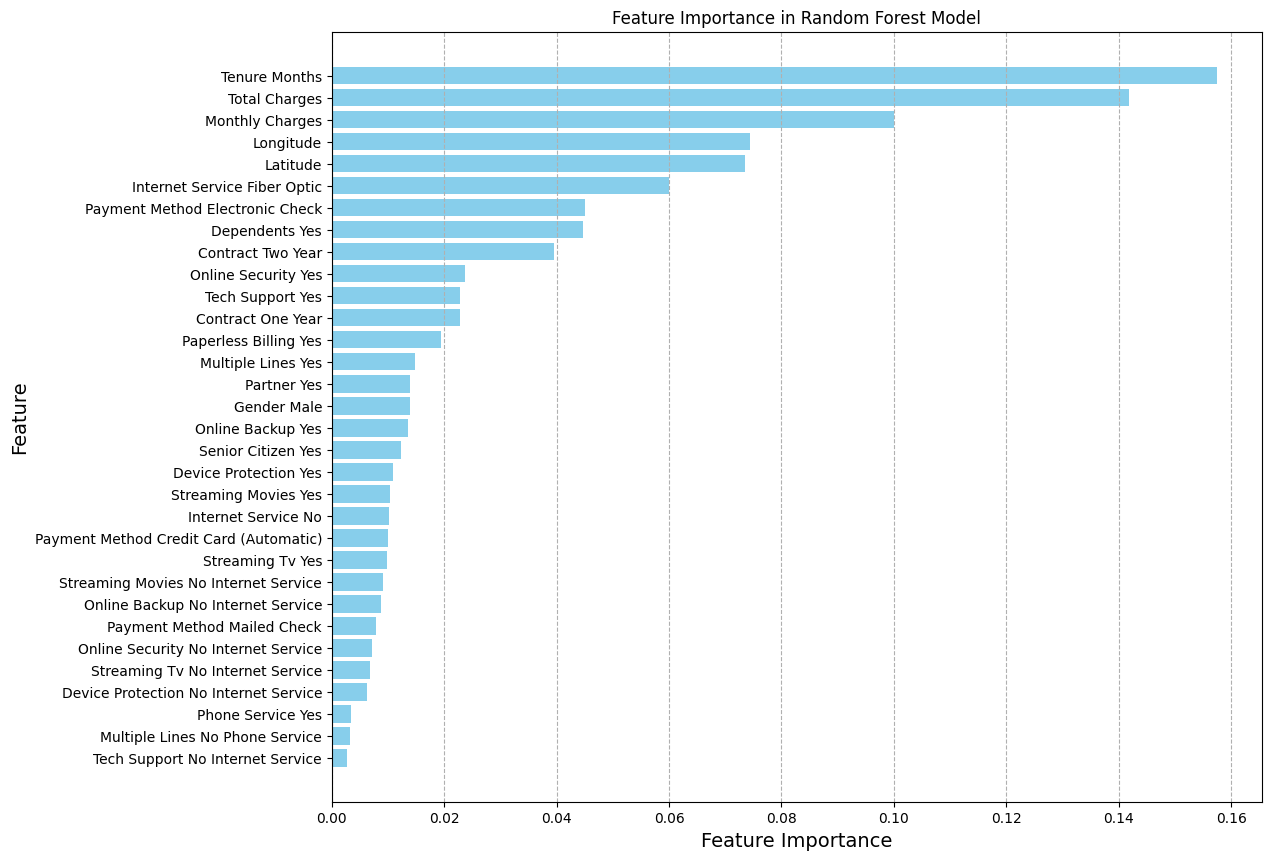

In [ ]:
feature_importances = rf_model.best_estimator_.feature_importances_

# Get feature names after one-hot encoding
preprocessor_fitted = model.named_steps['preprocess']
feature_names_out = preprocessor_fitted.get_feature_names_out()

# Create a DataFrame for easier plotting
feature_importance_df = pd.DataFrame({'feature': feature_names_out, 'importance': feature_importances})

# Sort by importance for better visualization
feature_importance_df = feature_importance_df.sort_values('importance', ascending=True)
feature_importance_df['feature'] = feature_importance_df['feature'].str.replace("_", " ").str[5:].str.title()

# Plotting
plt.figure(figsize=(12, 10))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='skyblue')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Random Forest Model')
plt.grid(axis='x', linestyle='--')
plt.show()

#**Decision Trees - XGBoost**
After trying random forests, let us try this classification with Extreme Gradient Boosting, or the stacking of small trees.

In [ ]:
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist'
)
model = Pipeline([
    ('preprocess', preprocessor),
    ('xgb', xgb)
])
model.fit(X_train, y_train)
xgb_model = model.named_steps['xgb']
y_pred_xg = model.predict(X_test)
y_hat_xg = model.predict_proba(X_test)[:,1]

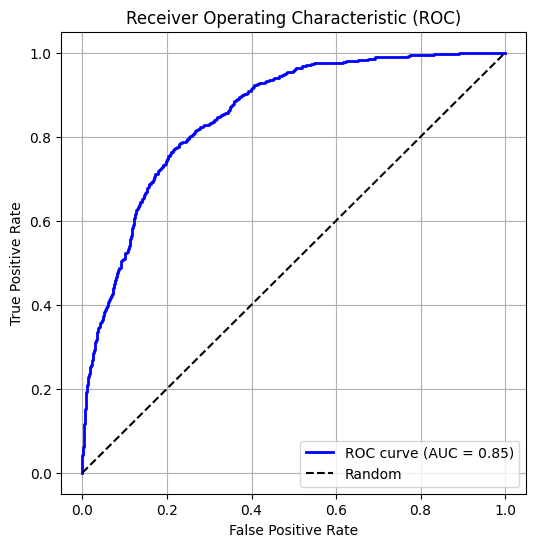

ROC-AUC: 0.8549670015304175


In [ ]:
make_roc_curve(y_test, y_hat_xg)
print(f"ROC-AUC: {roc_auc_score(y_test, y_hat_xg)}")

In [ ]:
print(classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1684
           1       0.65      0.53      0.58       641

    accuracy                           0.79      2325
   macro avg       0.74      0.71      0.72      2325
weighted avg       0.78      0.79      0.78      2325



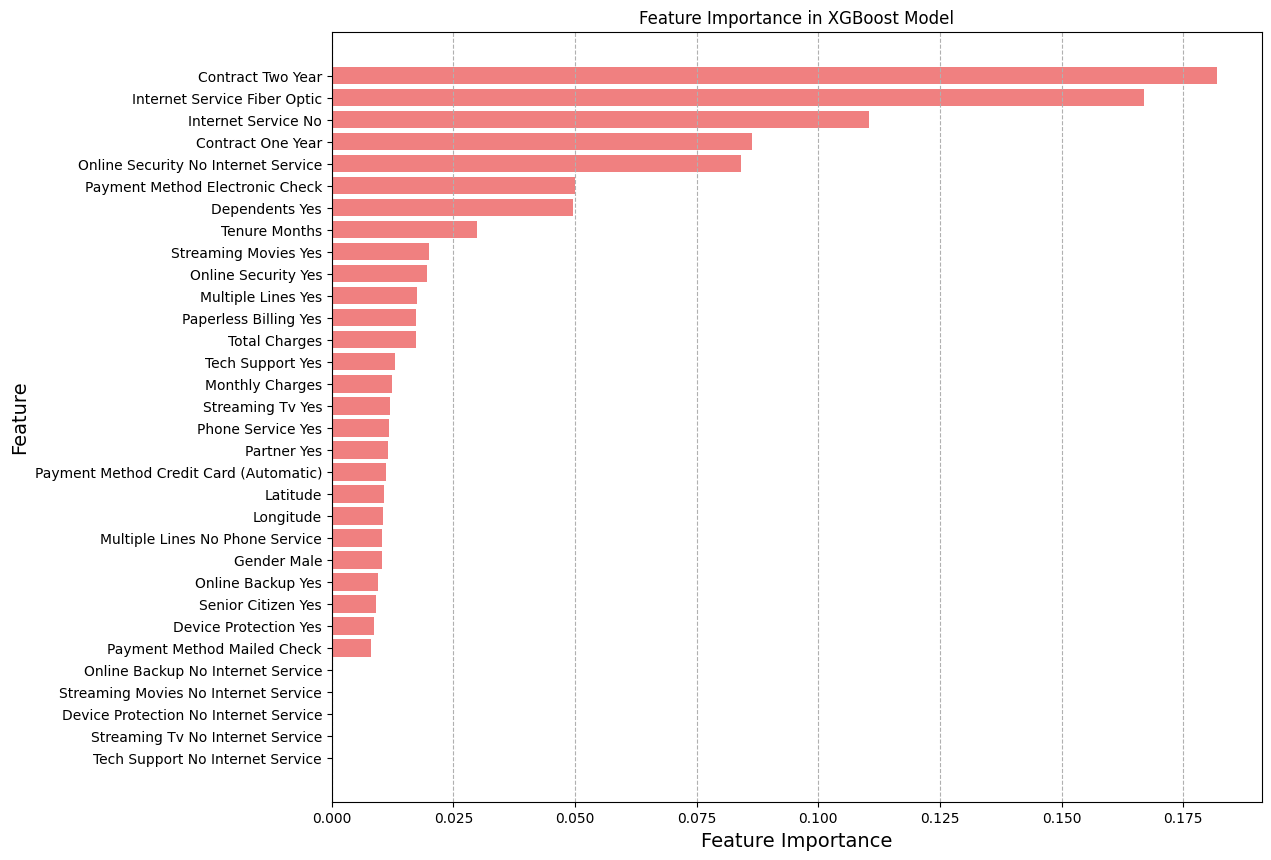

In [ ]:
feature_importances_xgb = xgb_model.feature_importances_
preprocessor_fitted = model.named_steps['preprocess']
feature_names_out = preprocessor_fitted.get_feature_names_out()
feature_importance_df_xgb = pd.DataFrame({'feature': feature_names_out, 'importance': feature_importances_xgb})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values('importance', ascending=True)

plt.figure(figsize=(12, 10))
feature_importance_df_xgb['feature'] = feature_importance_df_xgb['feature'].str[5:].str.replace("_", " ").str.title()
plt.barh(feature_importance_df_xgb['feature'], feature_importance_df_xgb['importance'], color='lightcoral')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in XGBoost Model')
plt.grid(axis='x', linestyle='--')
plt.show()

#**Visualizing All of the Models Together**

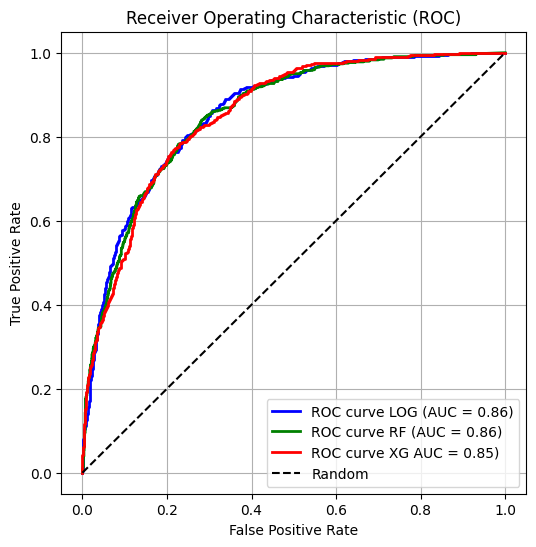

In [ ]:

fpr_log, tpr_log, thresholds = roc_curve(y_test, y_hat_log)
roc_auc_log = auc(fpr_log, tpr_log)

fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_hat_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xg, tpr_xg, thresholds = roc_curve(y_test, y_hat_xg)
roc_auc_xg = auc(fpr_xg, tpr_xg)


# Plot
plt.figure(figsize=(6,6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2, label=f'ROC curve LOG (AUC = {roc_auc_log:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'ROC curve RF (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xg, tpr_xg, color='red', lw=2, label=f'ROC curve XG AUC = {roc_auc_xg:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

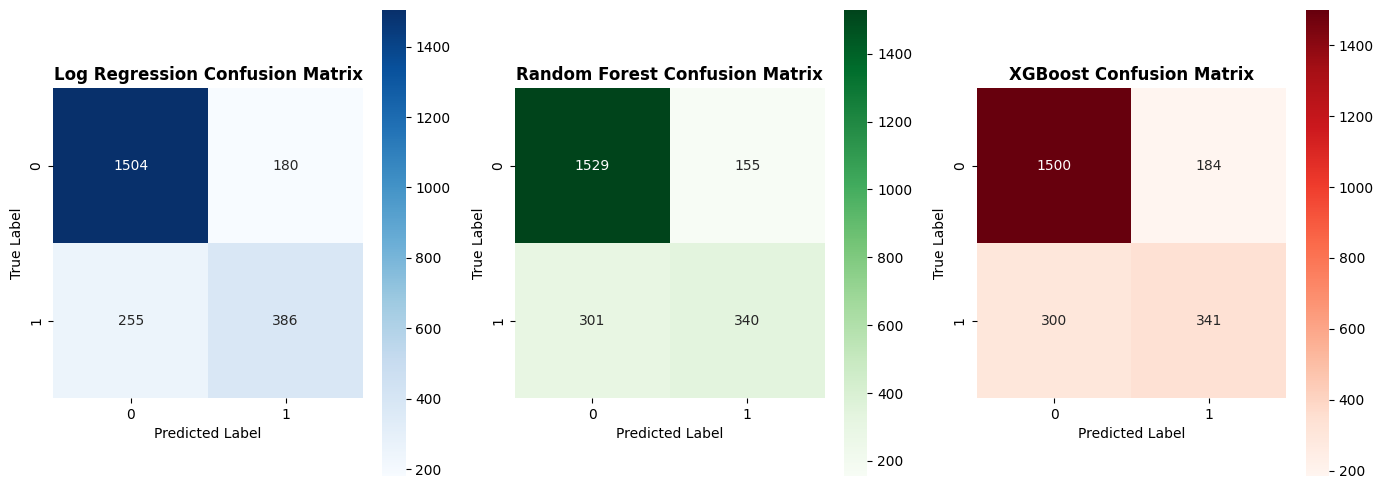

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# LR
cm_xgb = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            cbar=True, square=True)
axes[0].set_title('Log Regression Confusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            cbar=True, square=True)
axes[1].set_title('Random Forest Confusion Matrix', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

# XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xg)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Reds', ax=axes[2],
            cbar=True, square=True)
axes[2].set_title('XGBoost Confusion Matrix', fontsize=12, fontweight='bold')
axes[2].set_ylabel('True Label')
axes[2].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

#Analysis
Looking at the above ROC Curves and Confusion Matrices, we see very similar performance on all three methods.  Looking at the confusion matrix, we see that logistic regression had the highest precision, but also the worst specificity.  Given that we are trying to predict churn, we would select the model with the best precision, at the cost of having considerably more false positives than a model like random forest.  Random forest had the best prediction on no churn, but barely above 50% precision.  In general, the most simplistic model is also the best model by Occam's Razor.  

Possible reasions for Logistic Regression Success: Low Noise in Data, Simplistic Underlying Model of Data (potentially linear)

Possible Reasions for Underperformance of Decision Tree Methods: Overfitting

In conclusion, our model winner is **Logistic Regression**